# Modellen met tranferlearning

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

# importeren van zelf geschreven modules
from Callbacks.RealTimePlotCallback import RealTimePlotCallback
from dataset_module import dataset_creation

In [2]:
while os.getcwd() != "C:\\My Projects\\Opdracht-schilders":
    os.chdir('..')

os.chdir("4. Eigen Modellen/4.2 CNN met transfer learning")
os.getcwd()

'C:\\My Projects\\Opdracht-schilders\\4. Eigen Modellen\\4.2 CNN met transfer learning'

In [3]:
classes = os.listdir("../../datasets/paintings")

In [4]:
(train_data, train_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/train/")
(val_data, val_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/validation")
(test_data, test_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/test")

..\..\datasets\dataset\train\Picasso\150.jpg --> FAILED
..\..\datasets\dataset\test\Picasso\1503.jpg --> FAILED


## VGG16

In [5]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False)
conv_base.trainable = False


input_layer = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(input_layer)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

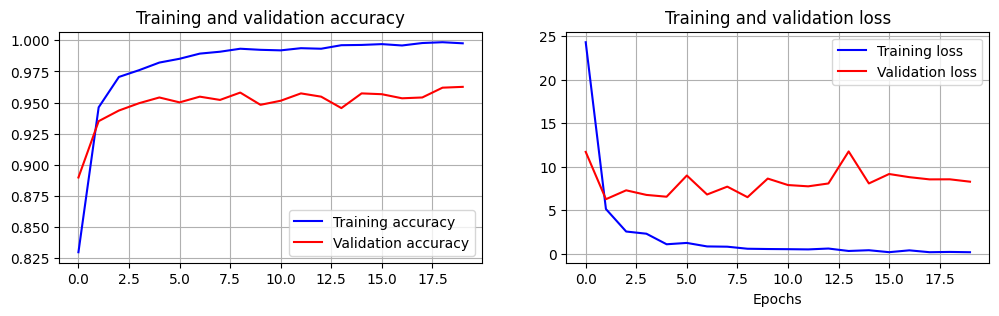

training loss: 0.15409348905086517
validation loss: 8.268531799316406
training accuracy: 0.9976029396057129
validation accuracy: 0.9626229405403137

epochs: 20

144/144 [==============================] - 20s 138ms/step - loss: 0.1541 - accuracy: 0.9976 - val_loss: 8.2685 - val_accuracy: 0.9626


In [6]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
         filepath="VGG16_base.keras",  # file waarin model wordt opgeslagen
         save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
         monitor="val_loss"),
     keras.callbacks.EarlyStopping(
         monitor="val_accuracy",
         patience=10),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=20,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

48/48 [==============================] - 7s 141ms/step


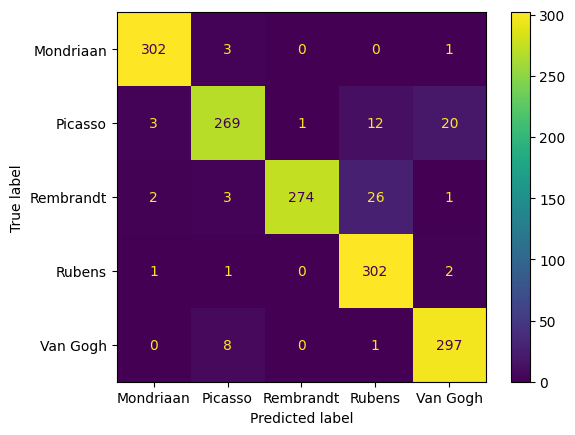

In [9]:
model = keras.models.load_model("VGG16_base.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Op de confusion matrix zien we dat het model Rembrandt soms verward met Rubens en Picasso soms verward met Van Gogh.

In [10]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 76ms/step - loss: 7.1120 - accuracy: 0.9444


[7.111979007720947, 0.944408118724823]

Het model heeft een **accuracy van 94%**, dit is goed. We zien wel dat we een **hoge loss hebben van 7.11**.

## Resnet

Ik zal nu dat ik VGG16 eens heb uitgeprobeerd, eens ResNet uitproberen.

In [5]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

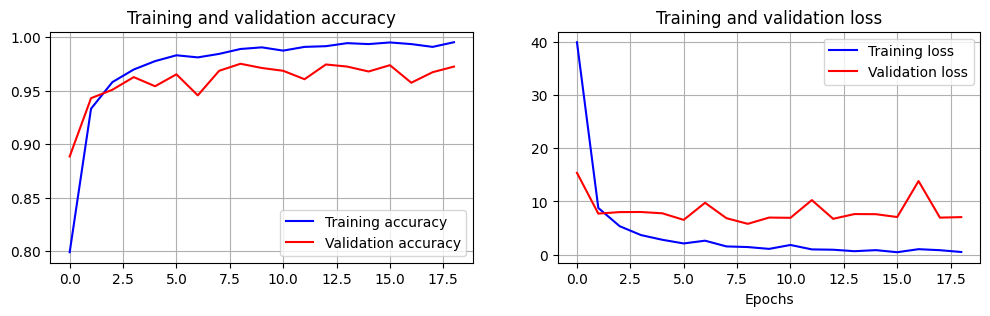

training loss: 0.5022587180137634
validation loss: 7.048577785491943
training accuracy: 0.9952059388160706
validation accuracy: 0.9724590182304382

epochs: 19

144/144 [==============================] - 14s 100ms/step - loss: 0.5023 - accuracy: 0.9952 - val_loss: 7.0486 - val_accuracy: 0.9725


In [7]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_basic.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

48/48 [==============================] - 4s 78ms/step


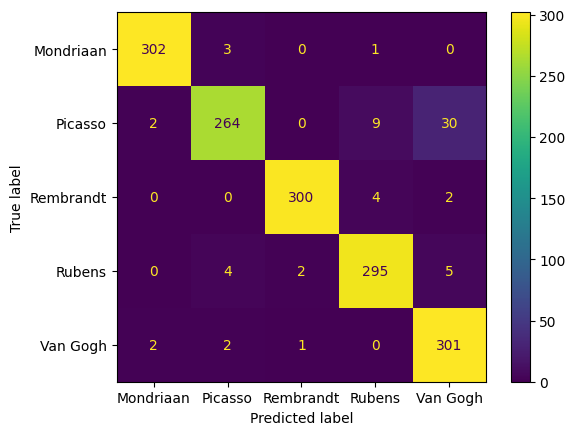

In [9]:
model = keras.models.load_model("ResNet_basic.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

We zien op de confusion matrix dat het model soms Picasso verward met Van Gogh. Anders dan dat ziet het er goed uit.

In [10]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 4s 68ms/step - loss: 9.9715 - accuracy: 0.9562


[9.971539497375488, 0.9561805129051208]

Het model behaalt heeft een **accuracy van 96%**, dit is beter dan het VGG16 model. Het heeft wel een hogere **loss** dan die van VGG16, namelijk **9.98**.